### Access swot river data through earthdata.

In [1]:
import os 
import earthaccess
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
dir_pixc_jinsha = 'data/jinsha-river/pixc'
dir_raster_jinsha = 'data/jinsha-river/raster'


In [3]:
auth = earthaccess.login()
time_range = ('2024-01-01 00:00:00', '2024-12-31 23:59:59')  ## temporal range.


#### 1. swot PIXC data.


In [4]:
links_list = []
results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0', 
                                    temporal = time_range,
                                    granule_name = '*_383_202R*',
                                    )
for r in range(len(results)):
    link = earthaccess.results.DataGranule.data_links(results[r], access='external')[0]
    links_list.append(link)
links_list = links_list[::2]  # Select every second link
print(len(links_list))
# earthaccess.download(links_list, dir_pixc_jinsha)


8


In [5]:
paths_file = [os.path.join(dir_pixc_jinsha, file) for file in os.listdir(dir_pixc_jinsha) if 'PIXC_' in file and '.nc' in file]
pixc_nc = xr.open_dataset(paths_file[0], group='pixel_cloud')
pixc_nc


<xarray.Dataset>
Dimensions:                                (points: 3291840, complex_depth: 2,
                                            num_pixc_lines: 3286)
Coordinates:
    latitude                               (points) float64 ...
    longitude                              (points) float64 ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/62)
    azimuth_index                          (points) float64 ...
    range_index                            (points) float64 ...
    interferogram                          (points, complex_depth) float32 ...
    power_plus_y                           (points) float32 ...
    power_minus_y                          (points) float32 ...
    coherent_power                         (points) float32 ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 ...
    data_window_first_valid                (num_pixc_lines) float64 ...
    data_window_last_valid                 (num_pixc_lines) float64 ...
    data_window_first_cross_track          (num_pixc_lines) float32 ...
    data_window_last_cross_track           (num_pixc_lines) float32 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3286
    interferogram_size_range:    6427
    looks_to_efflooks:           1.555133755565714
    num_azimuth_looks:           7.0
    azimuth_offset:              5

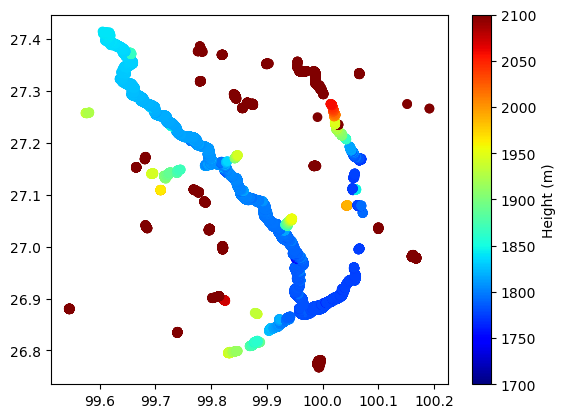

In [6]:
# mask to get good water pixels
mask = np.where(np.logical_and(pixc_nc.classification > 2, pixc_nc.geolocation_qual <= 64))
plt.scatter(x=pixc_nc.longitude[mask], y=pixc_nc.latitude[mask], c=pixc_nc.height[mask], cmap='jet')
plt.clim((1700, 2100))
plt.colorbar().set_label('Height (m)')


#### 2. swot raster data.


In [7]:
links_list = []
results = earthaccess.search_data(short_name = 'SWOT_L2_HR_Raster_2.0', 
                                    temporal = time_range,
                                    granule_name = '*_100m_*_383_101F*'
                                    )
for r in range(len(results)):
    lake_link = earthaccess.results.DataGranule.data_links(results[r], access='external')[0]
    links_list.append(lake_link)
links_list = links_list[::2]    ## Select every second link
print(len(links_list))
## earthaccess.download(links_list, dir_raster_jinsha)


8


In [8]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_raster_jinsha, file) 
                          for file in os.listdir(dir_raster_jinsha) 
                          if 'Raster_100m_' in file and '.nc' in file]
print(paths_file[0])
raster_nc = xr.open_dataset(paths_file[0], decode_times=False)
raster_nc


data/jinsha_river/raster/SWOT_L2_HR_Raster_100m_UTM47R_N_x_x_x_009_383_101F_20240117T194037_20240117T194058_PIC0_01.nc


<xarray.Dataset>
Dimensions:                  (x: 1485, y: 1484)
Coordinates:
  * x                        (x) float64 4.745e+05 4.746e+05 ... 6.229e+05
  * y                        (y) float64 2.896e+06 2.896e+06 ... 3.044e+06
Data variables: (12/39)
    crs                      object ...
    longitude                (y, x) float64 ...
    latitude                 (y, x) float64 ...
    wse                      (y, x) float32 ...
    wse_qual                 (y, x) float32 ...
    wse_qual_bitwise         (y, x) float64 ...
    ...                       ...
    load_tide_fes            (y, x) float32 ...
    load_tide_got            (y, x) float32 ...
    pole_tide                (y, x) float32 ...
    model_dry_tropo_cor      (y, x) float32 ...
    model_wet_tropo_cor      (y, x) float32 ...
    iono_cor_gim_ka          (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-01-21T15:10:38Z : Creation
    platform:                      SWOT
    references:                    V1.2
    ...                            ...
    x_min:                         474500.0
    x_max:                         622900.0
    y_min:                         2895800.0
    y_max:                         3044100.0
    institution:                   CNES
    product_version:               01

Text(0.5, 1.0, 'sig0')

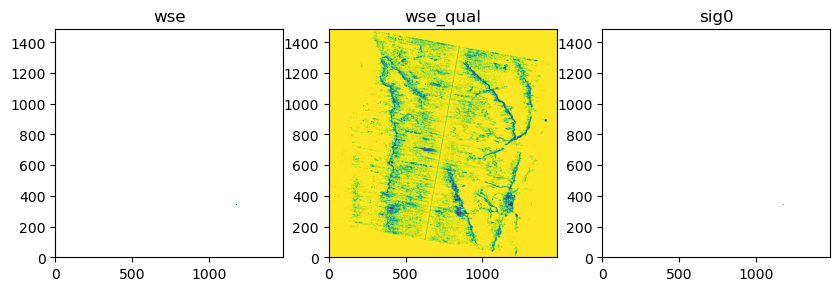

In [9]:
fig, ax = plt.subplots(1,3, figsize=(10, 3))
ax[0].imshow(raster_nc.wse, origin='lower'); ax[0].set_title('wse')
ax[1].imshow(raster_nc.wse_qual, origin='lower'); ax[1].set_title('wse_qual')
ax[2].imshow(raster_nc.sig0, vmin=-100, vmax=100, origin='lower'); ax[2].set_title('sig0')
